In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.set_context("poster")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import datetime
from scipy.stats import kurtosis

# Read all files, show first five rows and inspect for min, max, mean and shape

## train

In [2]:
train=pd.read_csv('train_2016_v2.csv')
train['transactiondate']=pd.to_datetime(train['transactiondate'])
train.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [3]:
train.shape

(90275, 3)

In [4]:
##Earliest Date
train.transactiondate.min()

Timestamp('2016-01-01 00:00:00')

In [5]:
##Latest Date
train.transactiondate.max()

Timestamp('2016-12-30 00:00:00')

In [6]:
#underestimated SalesPrice
train[train.logerror<0].shape[0]/train.shape[0]

0.43940182774854614

In [7]:
#overestimated SalesPrice
train[train.logerror>0].shape[0]/train.shape[0]

0.5512157297147604

In [8]:
#equal to Salesprice
train[train.logerror==0].shape[0]/train.shape[0]

0.009382442536693437

### About 43.9 % of the Salesprice is overestimated, 55.1% is underestimated and only 1% is predicted exactly as the Salesprice.  Next, let's look at the distribution of logerror.

### Logerror has a normal distribution

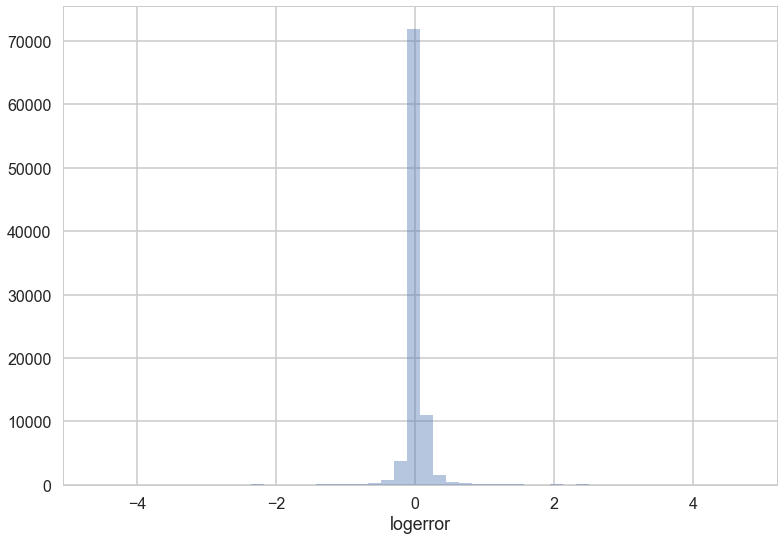

In [9]:
sns.distplot(train.logerror, kde=False)

### But what if we take the absolute logerror will it have the same character?

In [10]:
train['Absolute_logerror']=np.abs(train.logerror)

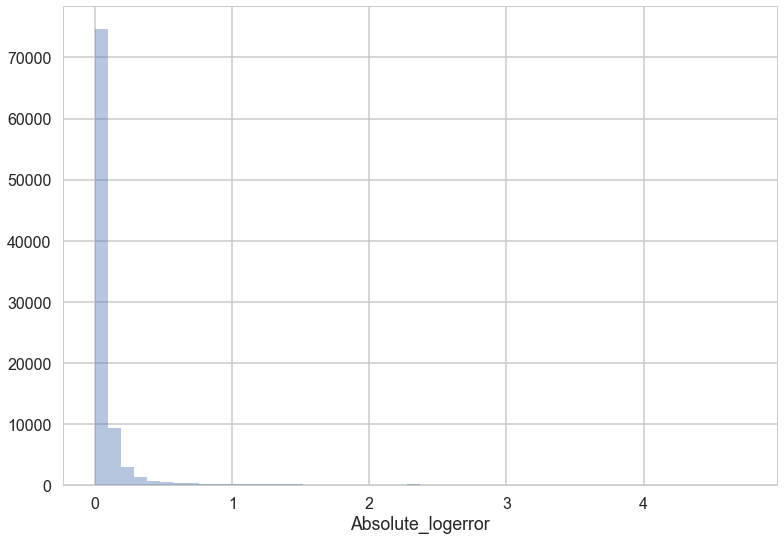

In [11]:
sns.distplot(train['Absolute_logerror'], kde=False)

### Absolute_logerror is left skewed 

## How does logerror and Absolute_logerror behave through time?

In [12]:
train.describe()

,parcelid,logerror,Absolute_logerror
count,9.027500e+04,90275.000000,90275.000000
mean,1.298466e+07,0.011457,0.068447
std,2.504510e+06,0.161079,0.146262
min,1.071174e+07,-4.605000,0.000000
25%,1.155950e+07,-0.025300,0.013900
50%,1.254734e+07,0.006000,0.032500
75%,1.422755e+07,0.039200,0.069400
max,1.629608e+08,4.737000,4.737000


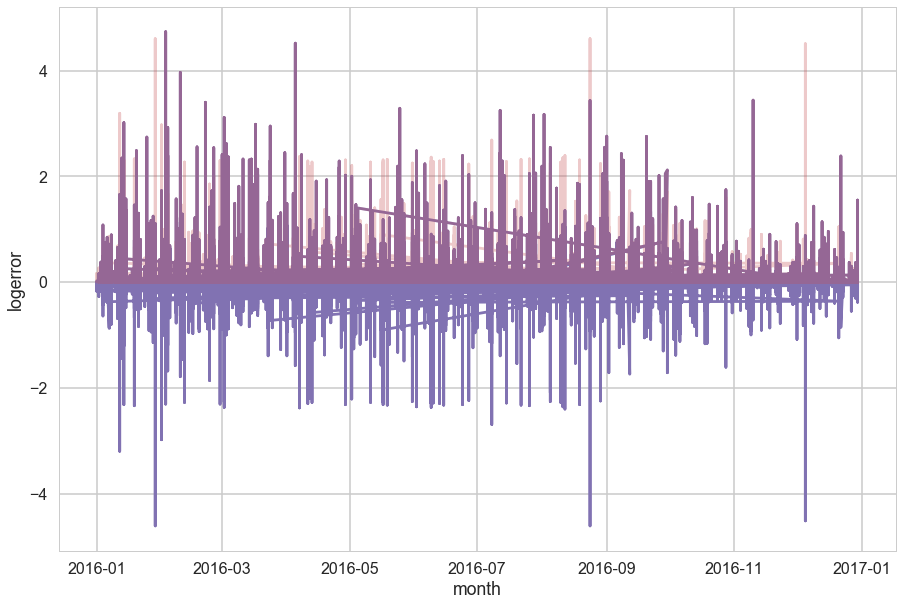

In [13]:
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(train.transactiondate, train.logerror, color='m')
plt.plot(train.transactiondate, train.Absolute_logerror, alpha=0.3, color='r')
plt.xlabel('month')
plt.ylabel('logerror')

## properties

In [14]:
properties=pd.read_csv('properties_2016.csv')
properties.head()

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [15]:
properties.shape

(2985217, 58)

In [16]:
properties.describe()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,2.985217e+06,811519.000000,6061.000000,1628.000000,2.973755e+06,2.973767e+06,12629.000000,1.938488e+06,2.856305e+06,17096.0,...,2647.000000,2.925289e+06,682069.000000,2.930235e+06,2.942667e+06,2.973778e+06,2.917484e+06,2.953967e+06,56464.000000,2.910091e+06
mean,1.332586e+07,1.931166,7.202607,646.883292,2.209143e+00,3.088949e+00,3.725948,5.784787e+00,2.299263e+00,66.0,...,278.296562,1.964262e+03,1.401464,1.708836e+05,4.204790e+05,2.014999e+03,2.524780e+05,5.377607e+03,13.892409,6.048431e+13
std,7.909966e+06,3.148587,2.436290,538.793473,1.077754e+00,1.275859e+00,0.501700,1.805352e+00,1.000736e+00,0.0,...,369.731508,2.344132e+01,0.539076,4.020683e+05,7.263467e+05,3.683161e-02,4.450132e+05,9.183107e+03,2.581006,3.249035e+11
min,1.071172e+07,1.000000,2.000000,20.000000,0.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,66.0,...,10.000000,1.801000e+03,1.000000,1.000000e+00,1.000000e+00,2.000000e+03,1.000000e+00,1.340000e+00,0.000000,-1.000000e+00
25%,1.164371e+07,1.000000,7.000000,272.000000,2.000000e+00,2.000000e+00,3.000000,4.000000e+00,2.000000e+00,66.0,...,96.000000,1.950000e+03,1.000000,7.480000e+04,1.796750e+05,2.015000e+03,7.483600e+04,2.461070e+03,14.000000,6.037400e+13
50%,1.254509e+07,1.000000,7.000000,534.000000,2.000000e+00,3.000000e+00,4.000000,7.000000e+00,2.000000e+00,66.0,...,168.000000,1.963000e+03,1.000000,1.225900e+05,3.060860e+05,2.015000e+03,1.670420e+05,3.991780e+03,14.000000,6.037572e+13
75%,1.409712e+07,1.000000,7.000000,847.250000,3.000000e+00,4.000000e+00,4.000000,7.000000e+00,3.000000e+00,66.0,...,320.000000,1.981000e+03,2.000000,1.968890e+05,4.880000e+05,2.015000e+03,3.069180e+05,6.201005e+03,15.000000,6.059042e+13
max,1.696019e+08,13.000000,27.000000,8516.000000,2.000000e+01,2.000000e+01,5.000000,1.200000e+01,2.000000e+01,66.0,...,6141.000000,2.015000e+03,41.000000,2.514860e+08,2.827860e+08,2.016000e+03,9.024622e+07,3.458861e+06,99.000000,4.830301e+14


In [17]:
sample_submission=pd.read_csv('sample_submission.csv')
sample_submission.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


In [18]:
zillow_dictionary=pd.read_excel('zillow_data_dictionary.xlsx')
zillow_dictionary.head()

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (i...
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, ..."
2,'basementsqft',Finished living area below or partially below...
3,'bathroomcnt',Number of bathrooms in home including fractio...
4,'bedroomcnt',Number of bedrooms in home


In [19]:
zillow_dictionary.shape

(58, 2)

## Merge train and properties dataframe (how=inner) - "all_train"

In [79]:
all_train=train.merge(properties, how='inner')
all_train.set_index('parcelid', inplace=True)
all_train.shape

(90275, 60)

In [49]:
missing_data_train=all_train.isnull().sum().sort_values()

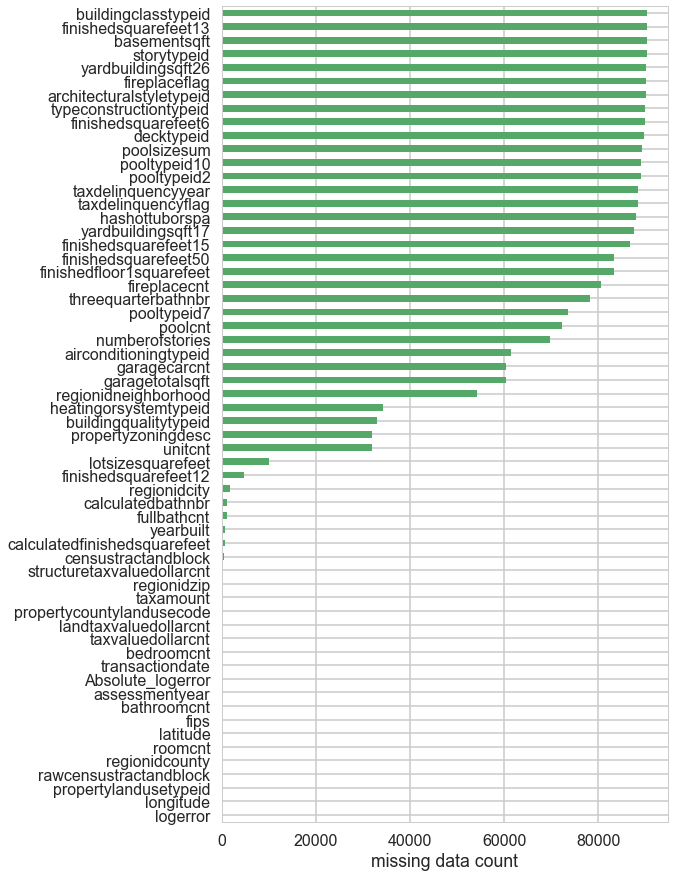

In [50]:
fig, ax = plt.subplots(figsize=(8,15))
missing_data_train.plot(kind='barh', color='g')
plt.xlabel('missing data count')

In [80]:
all_train.shape
all_train

,logerror,transactiondate,Absolute_logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,0.0276,2016-01-01,0.0276,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
14366692,-0.1684,2016-01-01,0.1684,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
12098116,-0.0040,2016-01-01,0.0040,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
12643413,0.0218,2016-01-02,0.0218,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
14432541,-0.0050,2016-01-02,0.0050,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13
11509835,-0.2705,2016-01-02,0.2705,1.0,NaN,NaN,4.0,4.0,NaN,1.0,...,NaN,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.57,NaN,NaN,6.037621e+13
12286022,0.0440,2016-01-02,0.0440,NaN,NaN,NaN,1.0,2.0,NaN,7.0,...,NaN,NaN,64549.0,111521.0,2015.0,46972.0,2304.97,NaN,NaN,6.037542e+13
17177301,0.1638,2016-01-02,0.1638,NaN,NaN,NaN,2.5,3.0,NaN,NaN,...,2.0,NaN,107000.0,306000.0,2015.0,199000.0,3745.50,NaN,NaN,6.111003e+13
14739064,-0.0030,2016-01-02,0.0030,NaN,NaN,NaN,1.0,2.0,NaN,NaN,...,NaN,NaN,66834.0,210064.0,2015.0,143230.0,2172.88,NaN,NaN,6.059042e+13


In [81]:
all_train=all_train.loc[:, ['logerror', 'transactiondate', 'bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet', 'fips','latitude', 'longitude', 'propertylandusetypeid','rawcensustractandblock','roomcnt','yearbuilt', 'landtaxvaluedollarcnt','taxvaluedollarcnt','structuretaxvaluedollarcnt', 'taxamount', 'censustractandblock']]
all_train.shape

(90275, 17)

In [82]:
all_train['transactiondate']=all_train['transactiondate'].dt.strftime('%Y%m%d')
all_train['transactiondate']=pd.to_numeric(all_train['transactiondate'])


In [99]:
all_train=all_train.dropna()
all_train.isnull().sum()

logerror                        0
transactiondate                 0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
propertylandusetypeid           0
rawcensustractandblock          0
roomcnt                         0
yearbuilt                       0
landtaxvaluedollarcnt           0
taxvaluedollarcnt               0
structuretaxvaluedollarcnt      0
taxamount                       0
censustractandblock             0
dtype: int64

In [130]:
##Correlation coefficient for logerror
pearson_coeff=pd.DataFrame(all_train.corr())
pearson_coeff.logerror

logerror                        1.000000
transactiondate                 0.004513
bathroomcnt                     0.027586
bedroomcnt                      0.025157
calculatedfinishedsquarefeet    0.038814
fips                            0.007989
latitude                        0.006623
longitude                      -0.004760
propertylandusetypeid           0.001196
rawcensustractandblock          0.008016
roomcnt                         0.005917
yearbuilt                       0.016981
landtaxvaluedollarcnt          -0.001072
taxvaluedollarcnt               0.007217
structuretaxvaluedollarcnt      0.021295
taxamount                      -0.005012
censustractandblock             0.008057
Name: logerror, dtype: float64

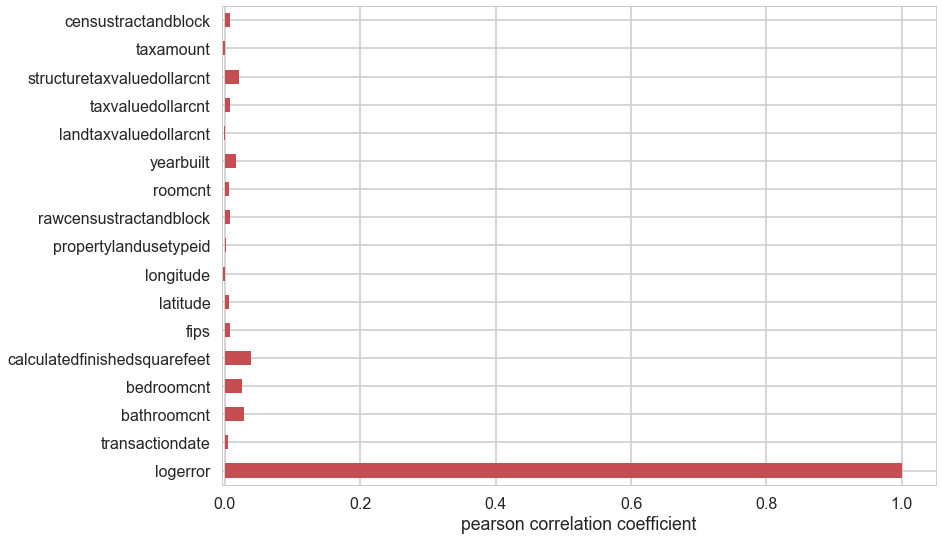

In [132]:
pearson_coeff.logerror.plot(kind='barh', color='r')
plt.xlabel('pearson correlation coefficient')

In [100]:
X=all_train.iloc[:, 2:]
y=all_train.logerror

In [101]:
X.isnull().sum()

bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
propertylandusetypeid           0
rawcensustractandblock          0
roomcnt                         0
yearbuilt                       0
landtaxvaluedollarcnt           0
taxvaluedollarcnt               0
structuretaxvaluedollarcnt      0
taxamount                       0
censustractandblock             0
dtype: int64

In [103]:
##Split  all_num to test and train dataset
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=1)

RFR=RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42, n_jobs=1)
lm=LinearRegression()

In [104]:
##Let's create the models using the 15 features with the least missing values 

In [105]:
## Linear Regression
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [106]:
y_pred_linear=lm.predict(X_test)

In [107]:
mae(y_test, y_pred_linear)

0.067261017108850893

In [110]:
## Random Forest
RFR.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [111]:
RFR.oob_score_

-0.060028341542301522

In [112]:
y_pred_random=RFR.predict(X_test)

In [113]:
mae(y_test, y_pred_random)

0.073393872329147361

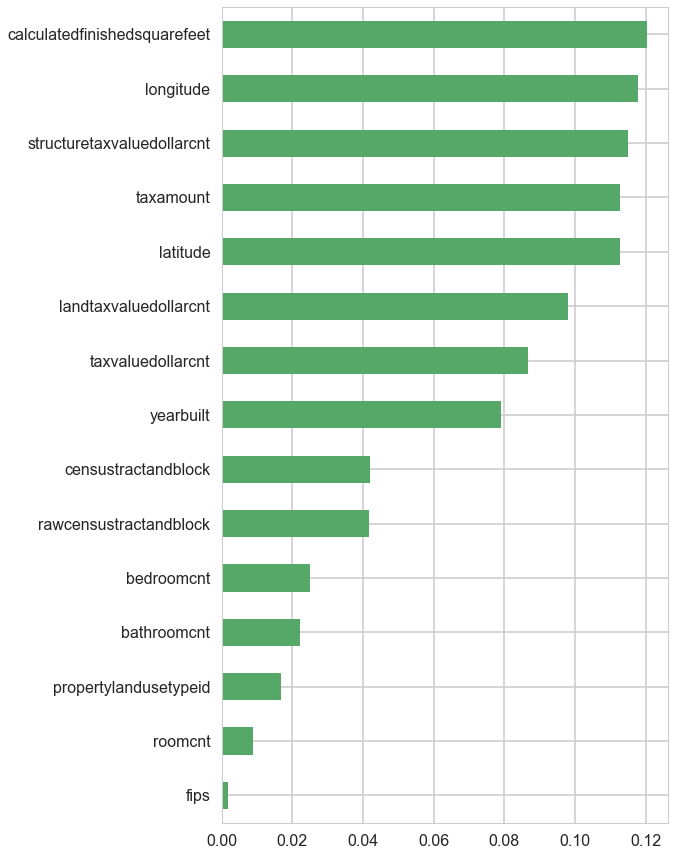

In [114]:
fig, ax = plt.subplots(figsize=(8,15))
feature_importances=pd.Series(RFR.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh', color='g')

## Now let's reduce the features to the top 5 most important features

In [115]:
X_new=X.loc[:, ['calculatedfinishedsquarefeet', 'longitude','structuretaxvaluedollarcnt', 'latitude', 'taxamount' ]]

In [116]:
X_train, X_test, y_train, y_test=train_test_split(X_new, y, random_state=1)

In [117]:
lm.fit(X_train, y_train)  

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [118]:
y_pred_linear=lm.predict(X_test)

In [119]:
mae(y_test, y_pred_linear)

0.067330201490965524

In [120]:
RFR.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [121]:
y_pred_random=RFR.predict(X_test)

In [122]:
mae(y_test, y_pred_random)

0.073996757076977671

1. What changes can we do to improve the model? 
2. What other ML can we use to reduce mae?
3. How do we incorporate time since we need to predict MAE at different time?